## Keyword Extraction using MAUI

MAUI is a machine learning model for keyword extraction, developed by Alyona Medelyan, part of the group that built WEKA. See [NLP Keyword Extraction Tutorial with RAKE and Maui](https://www.airpair.com/nlp/keyword-extraction-tutorial) for details.

We will use here the keywords we have extracted already (`candidate_bigrams.tsv` and `candidate_rake.tsv` files) to train a MAUI model, and then run the model against the same data files to hopefully get more keyword candidates.

Download the JAR file from the [maui-standalone JAR release repository](https://github.com/zelandiya/maui-standalone/releases) to a local directory.

In [1]:
import collections
import matplotlib.pyplot as plt
import os
import sqlite3
%matplotlib inline

In [2]:
DATA_DIR = "../data"

TEXTFILES_DIR = os.path.join(DATA_DIR, "textfiles")
TRAIN_KEYWORDS_DIR = os.path.join(DATA_DIR, "keywords")

WORDCOUNTS_DB = os.path.join(DATA_DIR, "wordcounts.db")
LLR_CANDIDATES = os.path.join(DATA_DIR, "candidate_bigrams.tsv")
RAKE_CANDIDATES = os.path.join(DATA_DIR, "candidate_rake.tsv")

PREDICTED_KEYWORDS_DIR = os.path.join(DATA_DIR, "keywords_maui")
MAUI_CANDIDATES = os.path.join(DATA_DIR, "candidate_maui.tsv")

### Build training dataset

For each document, we will first look up the `bigrams` table for all bigrams for that document, and filter them by the list in `candidate_bigrams.tsv` file. We will do the same with the `rake` table and filter with `candidate_rake.tsv`. The resulting de-duplicated list of keywords will be written out to the `keywords/${doc_id}.key` file.

In [3]:
def get_valid_llr_keywords(candidate_filename):
    valid_bigrams = set()
    fcand = open(candidate_filename, "r")
    for line in fcand:
        word_1, word_2, _ = line.strip().split("\t")
        keyword = " ".join([word_1, word_2])
        valid_bigrams.add(keyword)
    fcand.close()
    return valid_bigrams


def get_llr_keywords(conn, doc_id, valid_keywords):
    llr_keywords = set()
    cur = conn.cursor()
    cur.execute("""select word_1, word_2 from bigrams
        where doc_id = ?""", [doc_id])
    rows = cur.fetchall()
    for row in rows:
        keyword = " ".join([row[0], row[1]])
        if keyword in valid_keywords:
            llr_keywords.add(keyword)
    cur.close()
    return llr_keywords


def get_valid_rake_keywords(candidate_filename):
    valid_keywords = set()
    fcand = open(candidate_filename, "r")
    for line in fcand:
        keyword, _ = line.strip().split("\t")
        valid_keywords.add(keyword)
    fcand.close()
    return valid_keywords


def get_rake_keywords(conn, doc_id, valid_keywords):
    rake_keywords = set()
    cur = conn.cursor()
    cur.execute("""select keyword from rake where doc_id = ?""", [doc_id])
    rows = cur.fetchall()
    for row in rows:
        rake_keywords.add(row[0])
    cur.close()
    return rake_keywords

In [4]:
if not os.path.exists(TRAIN_KEYWORDS_DIR):
    os.makedirs(TRAIN_KEYWORDS_DIR)

    conn = sqlite3.connect(WORDCOUNTS_DB)
    
    valid_llr_keywords = get_valid_llr_keywords(LLR_CANDIDATES)
    valid_rake_keywords = get_valid_rake_keywords(RAKE_CANDIDATES)
    
    i = 0
    for textfile in os.listdir(TEXTFILES_DIR):
        if i % 100 == 0:
            print("{:d} keyfiles written".format(i))
        doc_id = int(textfile.split(".")[0])
        llr_keywords = get_llr_keywords(conn, doc_id, valid_llr_keywords)
        rake_keywords = get_rake_keywords(conn, doc_id, valid_rake_keywords)
        keywords = llr_keywords.union(rake_keywords)
        fkey = open(os.path.join(TRAIN_KEYWORDS_DIR, "{:d}.key".format(doc_id)), "w")
        for keyword in keywords:
            num_words = len(keyword.split(" "))
            # don't care for 1 word keywords
            if num_words < 2:
                continue
            fkey.write("{:s}\n".format(keyword))
        fkey.close()
        i += 1
        
    print("{:d} keyfiles written, COMPLETE".format(i))

### Train MAUI model

Train a model. Both the text file and keyword files should be in same directory. 

    cd ../data
    mkdir train_dir
    cp textfiles/* train_dir/
    cp keywords/* train_dir/
    
    cd ../models
    java -Xmx4096m -jar maui-standalone-1.1-SNAPSHOT.jar train \
        -l ../data/train_dir/ \
        -m ./keyword_extraction.model \
        -v none \
        -o 5 \
        -x 4 \
        -y 2
        
    cd ../data
    rm -rf train_dir

This will create a model `keyword_extraction.model` in the current `models` directory. The `-x 4 -y 2` parameters state that we want only keywords that are between 2 and 4 words long. The `-o 5` only looks at keywords which occur 5 or more times. The `-v none` specifies that we are not supplying a vocabulary.

### Predict using model

Once the model is ready, we can run this against the `.txt` files in our `../data/textfiles` directory. This will create additional keyword `.maui` files in the same directory, which will have to remove later to its own directory.

    cd ../model
    java -Xmx4096m -jar maui-standalone-1.1-SNAPSHOT.jar test \
        -l ../data/textfiles/ \
        -m ./keyword_extraction.model \
        -v none \
        -n 8

    cd ../data
    mkdir keywords_maui
    mv textfiles/*.maui keywords_maui/
    
Here `-n 8` says we want MAUI to generate 8 keywords for each of our documents.

### Record keywords into DB

We will now store these into a DB table, since we will need it to generate a list of "good" keywords from all three keyword generation approaches, to put into the index.

In [5]:
def table_exists(conn, table_name):
    cur = conn.cursor()
    cur.execute("select name from sqlite_master where type='table' and name = ?", 
                [table_name])
    rows = cur.fetchall()
    cur.close()
    return len(rows) > 0


def create_maui_table(conn):
    if not table_exists(conn, "maui"):
        cur = conn.cursor()
        create_table = """create table maui(
            id INTEGER NOT NULL,
            keyword VARCHAR(50) NOT NULL, 
            doc_id INTEGER NOT NULL)
        """
        cur.execute(create_table)
        cur.close()


def index_exists(conn, index_name):
    cur = conn.cursor()
    cur.execute("select name from sqlite_master where type='index' and name = ?", 
                [index_name])
    rows = cur.fetchall()
    cur.close()
    return len(rows) > 0


def create_maui_indexes(conn):
    cur = conn.cursor()
    index_names = ["ix_maui", "ax1_maui", "ax2_maui"]
    create_indexes = [
        "create unique index ix_maui on maui(id)",
        "create index ax1_maui on maui(keyword)",
        "create index ax2_maui on maui(doc_id)"
    ]
    for index_name, create_index in zip(index_names, create_indexes):
        if not index_exists(conn, index_name):
            cur.execute(create_index)
    cur.close()


def insert_keyword(conn, id, keyword, doc_id, commit=False):
    cur = conn.cursor()
    cur.execute("insert into maui(id, keyword, doc_id) values (?, ?, ?)", 
                [id, keyword, doc_id])
    if commit:
        conn.commit()
    cur.close()

        
def count_maui_keywords(conn):
    cur = conn.cursor()
    cur.execute("select count(*) as cnt from maui")
    rows = cur.fetchone()
    return int(rows[0])
    cur.close()


conn = sqlite3.connect(WORDCOUNTS_DB)
create_maui_table(conn)

In [6]:
num_recs = count_maui_keywords(conn)
if num_recs == 0:
    keyword_id = 0
    should_commit = False
    for keyfile in os.listdir(PREDICTED_KEYWORDS_DIR):
        if keyword_id % 1000 == 0:
            print("{:d} keywords ingested".format(keyword_id))
            should_commit = True
        doc_id = int(keyfile.split(".")[0])
        fkey = open(os.path.join(PREDICTED_KEYWORDS_DIR, keyfile), "r")
        for keyword in fkey:
            keyword = keyword.strip()
            insert_keyword(conn, keyword_id, keyword, doc_id, should_commit)
            keyword_id += 1
            should_commit = False
        fkey.close()
    print("{:d} keywords ingested, COMPLETE".format(keyword_id))
    conn.commit()

In [7]:
create_maui_indexes(conn)

### Aggregate generated keywords

In [8]:
i = 0
keywordsFreq = collections.Counter()
for keyfile in os.listdir(PREDICTED_KEYWORDS_DIR):
    if i % 1000 == 0:
        print("{:d} key files read".format(i))
    fmaui = open(os.path.join(PREDICTED_KEYWORDS_DIR, keyfile), "r")
    for keyword in fmaui:
        keywordsFreq[keyword.strip()] += 1
    fmaui.close()
    i += 1

print("{:d} key files read".format(i))
print("{:d} unique keywords".format(len(keywordsFreq)))

0 key files read
1000 key files read
2000 key files read
3000 key files read
4000 key files read
5000 key files read
6000 key files read
7000 key files read
7238 key files read
13712 unique keywords


In [9]:
for keyword, freq in keywordsFreq.most_common(20):
    print(keyword, freq)

Machine Learning 792
neural networks 644
training set 497
neural network 404
Neural Information 401
Processing Systems 400
Information Processing 398
International Conference 394
training data 384
lower bound 383
preprint arXiv 378
machine learning 374
data set 369
optimization problem 332
upper bound 324
learning algorithm 311
loss function 287
objective function 280
gradient descent 274
reinforcement learning 260


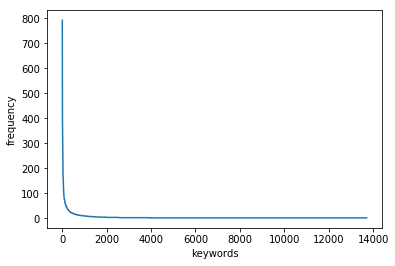

In [10]:
freqs = [f for k, f in keywordsFreq.most_common()]
plt.plot(freqs)
plt.xlabel("keywords")
plt.ylabel("frequency")
plt.show()

In [11]:
fmac = open(MAUI_CANDIDATES, "w")
already_seen = set()
for keyword, freq in keywordsFreq.most_common(1000):
    keyword = keyword.lower()
    if keyword in already_seen:
        continue
    fmac.write("{:s}\t{:d}\n".format(keyword, freq))
    already_seen.add(keyword)
fmac.close()

## Next steps

We now have keywords from 3 sources, which we will merge, dedup and then manually curate before putting them in our index.

    cd ../data
    cat candidate_bigrams.tsv | cut -f1-2 -d "\t" | tr "\t" " " > /tmp/aa1
    cat candidate_rake.tsv | cut -f1 -d"     " > /tmp/aa2
    cat candidate_maui.tsv | cut -f1 -d"     " > /tmp/aa3
    cat /tmp/aa1 /tmp/aa2 /tmp/aa3 | sort | uniq > /tmp/raw_keywords.txt
    